## ML Approaches for classification of target DBE 

### First approach drop prime vend and treat bid days as contiuous variable

In [166]:
from math import sqrt
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline as pipe
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import RareLabelEncoder, MeanEncoder,OneHotEncoder,OrdinalEncoder
from feature_engine.discretisation import DecisionTreeDiscretiser
from feature_engine.imputation import (
AddMissingIndicator,
MeanMedianImputer,
CategoricalImputer,
 )   
%matplotlib inline
SEED = 42

In [31]:
#options for pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
#pd.options.display.float_format = '{:.0f}'.format

In [32]:
data = pd.read_csv("multi_row_per_sample.csv") #Read the dataset

C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (2,3,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
data = data.drop('Unnamed: 0', 1)

In [34]:
data.drop(data.iloc[:, 47:216], inplace=True, axis=1)

In [35]:
data = data.drop('LN_ITM_NBR', 1)
data = data.drop('PRD_END_DT', 1)
data = data.drop('EST_T', 1)
data = data.drop('current_item_payment_amount', 1)
data = data.drop('payments_cumsum', 1)
data = data.drop('Bin 1 (%)', 1)
data = data.drop('Bin 171 (%)', 1)

In [36]:
data.shape

(1080925, 41)

In [37]:
data.shape

(1080925, 41)

In [38]:
#data.reset_index(drop=True, inplace=True)

In [39]:
data = data.drop('TOTAL_PD', 1)
data = data.drop('TOT_VERF_PAYM_AMT', 1)
data = data.drop('DBE_PAYSUM', 1)
data = data.drop('Subcontract_appr_date', 1)
data = data.drop('Subcontract_payment_date', 1)
data = data.drop('subcontract_payment_amount', 1)
data = data.drop('ITM_CD', 1)
data = data.drop('Item Unit', 1)
data = data.drop('Total Item Quantity', 1)
data = data.drop('Total Item Price ($)', 1)
data = data.drop('item_description', 1)
data = data.drop('LN_ITM_SUBC_QTY', 1)
data = data.drop('LN_ITM_SUBC_UNT', 1)
data = data.drop('LN_ITM_SUBC_PRIC', 1)
data = data.drop('sum_of_bins', 1)
data = data.drop('number_of_bins', 1)

In [40]:
data = data[data['BID_DAYS'].notna()]

In [23]:
data.shape

(1064985, 25)

In [41]:
data = data.sort_values(by='DBE_goal', ascending=False)


In [42]:
data.head(5)

,CONT_ID,PRJ_NBR,PRIME_VEND_ID,FUND_IND,FUNDTYPE,PROPOSAL_TYPE,SUB_VEND_ID,SUBCONT_NBR,DBE_T,DBE_COMMITMENT,DBEGOALPERCENT,DBE_Commit_Amount,DBE_Goal_Amount,proposal_estimated_amount,TOT_BID_AMT,START_DT,BID_DAYS,CLOSE_OUT_DT,EST_NBR,current_item_payment_quantity,number_of_payments,DBE_goal_status,DBE_commit_status,DBE_contract_target,DBE_goal
0,120035,2.7748e+06,201749126,B,0FED,INTERSECTION MODIFICATION AND TRAFFIC SIGNALS,731004991,1,DBE,2.42,2.0,1.221349e+04,10093.7960,550161.47,504689.80,02/12/2014,90.0,04/27/2016,6.0,1784.63,3,1,1,1,1
715137,140376,2793904,731316732,B,FED,BRIDGE AND APPROACHES,731564757,5,DBE,3.47,3.0,1.136562e+06,982618.2096,31954938.25,32753940.32,07/06/2015,580.0,06/18/2019,7.0,945.00,14574,1,1,1,1
715124,140376,2793904,731316732,B,FED,BRIDGE AND APPROACHES,731564757,5,DBE,3.47,3.0,1.136562e+06,982618.2096,31954938.25,32753940.32,07/06/2015,580.0,06/18/2019,22.0,208.00,14574,1,1,0,1
715125,140376,2793904,731316732,B,FED,BRIDGE AND APPROACHES,731564757,5,DBE,3.47,3.0,1.136562e+06,982618.2096,31954938.25,32753940.32,07/06/2015,580.0,06/18/2019,24.0,363.00,14574,1,1,0,1
715126,140376,2793904,731316732,B,FED,BRIDGE AND APPROACHES,731564757,5,DBE,3.47,3.0,1.136562e+06,982618.2096,31954938.25,32753940.32,07/06/2015,580.0,06/18/2019,25.0,60.00,14574,1,1,0,1


In [43]:
data = data.drop_duplicates(subset='CONT_ID', keep="first")

In [44]:
data.reset_index(drop=True, inplace=True)

In [45]:
data.head(5)

,CONT_ID,PRJ_NBR,PRIME_VEND_ID,FUND_IND,FUNDTYPE,PROPOSAL_TYPE,SUB_VEND_ID,SUBCONT_NBR,DBE_T,DBE_COMMITMENT,DBEGOALPERCENT,DBE_Commit_Amount,DBE_Goal_Amount,proposal_estimated_amount,TOT_BID_AMT,START_DT,BID_DAYS,CLOSE_OUT_DT,EST_NBR,current_item_payment_quantity,number_of_payments,DBE_goal_status,DBE_commit_status,DBE_contract_target,DBE_goal
0,120035,2.7748e+06,201749126,B,0FED,INTERSECTION MODIFICATION AND TRAFFIC SIGNALS,731004991,1,DBE,2.42,2.0,1.221349e+04,10093.7960,550161.47,504689.80,02/12/2014,90.0,04/27/2016,6.0,1784.63,3,1,1,1,1
1,140376,2793904,731316732,B,FED,BRIDGE AND APPROACHES,731564757,5,DBE,3.47,3.0,1.136562e+06,982618.2096,31954938.25,32753940.32,07/06/2015,580.0,06/18/2019,7.0,945.00,14574,1,1,1,1
2,150021,2790807,731561772,B,0FED,BRIDGE AND APPROACHES AND GUARDRAIL,731564757,6,DBE,2.16,2.0,2.676684e+05,247841.1042,12428625.76,12392055.21,01/04/2016,400.0,09/25/2018,29.0,1560.00,12726,1,1,1,1
3,140373,2798804,730764097A,B,0FED,BRIDGE AND APPROACHES,731564757,1,DBE,1.32,1.0,7.647172e+04,57933.1249,5377492.74,5793312.49,03/30/2015,300.0,03/15/2019,20.0,32.00,14600,1,1,0,1
4,150016,2958804,731394406,B,0FED,BRIDGE REHABILITATION,731564757,3,DBE,9.09,4.0,3.472402e+05,152800.9792,3491577.05,3820024.48,06/01/2015,300.0,10/22/2018,11.0,448.00,3923,1,1,1,1


In [46]:
data.shape

(473, 25)

In [47]:
data = data.drop('SUB_VEND_ID', 1)
data = data.drop('SUBCONT_NBR', 1)

In [48]:
data = data[data['DBE_COMMITMENT'] > 0]

In [49]:
data["PRJ_NBR"]= data["PRJ_NBR"].astype(str)

In [50]:
for var in data.columns:
    print(var, data[var].nunique(), len(data))

CONT_ID 472 472
PRJ_NBR 457 472
PRIME_VEND_ID 122 472
FUND_IND 2 472
FUNDTYPE 13 472
PROPOSAL_TYPE 68 472
DBE_T 1 472
DBE_COMMITMENT 340 472
DBEGOALPERCENT 18 472
DBE_Commit_Amount 472 472
DBE_Goal_Amount 472 472
proposal_estimated_amount 472 472
TOT_BID_AMT 472 472
START_DT 309 472
BID_DAYS 68 472
CLOSE_OUT_DT 350 472
EST_NBR 39 472
current_item_payment_quantity 292 472
number_of_payments 311 472
DBE_goal_status 2 472
DBE_commit_status 2 472
DBE_contract_target 2 472
DBE_goal 2 472


In [51]:
data.drop('CONT_ID', axis=1, inplace=True)

In [52]:
data.drop('DBE_goal_status', axis=1, inplace=True)
data.drop('DBE_commit_status', axis=1, inplace=True)
data.drop('DBE_contract_target', axis=1, inplace=True)

In [53]:
data.drop('PRIME_VEND_ID', axis=1, inplace=True)

In [54]:
data.drop('PRJ_NBR', axis=1, inplace=True)
data.drop('DBE_T', axis=1, inplace=True)
data.drop('proposal_estimated_amount', axis=1, inplace=True)
data.drop('START_DT', axis=1, inplace=True)
data.drop('CLOSE_OUT_DT', axis=1, inplace=True)
data.drop('EST_NBR', axis=1, inplace=True)
data.drop('current_item_payment_quantity', axis=1, inplace=True)
data.drop('number_of_payments', axis=1, inplace=True)

In [55]:
data.head(4)

,FUND_IND,FUNDTYPE,PROPOSAL_TYPE,DBE_COMMITMENT,DBEGOALPERCENT,DBE_Commit_Amount,DBE_Goal_Amount,TOT_BID_AMT,BID_DAYS,DBE_goal
0,B,0FED,INTERSECTION MODIFICATION AND TRAFFIC SIGNALS,2.42,2.0,1.221349e+04,10093.7960,504689.80,90.0,1
1,B,FED,BRIDGE AND APPROACHES,3.47,3.0,1.136562e+06,982618.2096,32753940.32,580.0,1
2,B,0FED,BRIDGE AND APPROACHES AND GUARDRAIL,2.16,2.0,2.676684e+05,247841.1042,12392055.21,400.0,1
3,B,0FED,BRIDGE AND APPROACHES,1.32,1.0,7.647172e+04,57933.1249,5793312.49,300.0,1


In [56]:
data_copy = data.copy()
corr_matrix = data_copy.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,DBE_COMMITMENT,DBEGOALPERCENT,DBE_Commit_Amount,DBE_Goal_Amount,TOT_BID_AMT,BID_DAYS,DBE_goal
DBE_COMMITMENT,NaN,0.224118,0.352813,0.067437,0.012342,0.017715,0.149015
DBEGOALPERCENT,NaN,NaN,0.391993,0.474341,0.292698,0.234445,0.010756
DBE_Commit_Amount,NaN,NaN,NaN,0.767867,0.739090,0.615467,0.106594
DBE_Goal_Amount,NaN,NaN,NaN,NaN,0.927759,0.712439,0.122152
TOT_BID_AMT,NaN,NaN,NaN,NaN,NaN,0.807918,0.149248
BID_DAYS,NaN,NaN,NaN,NaN,NaN,NaN,0.166087
DBE_goal,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

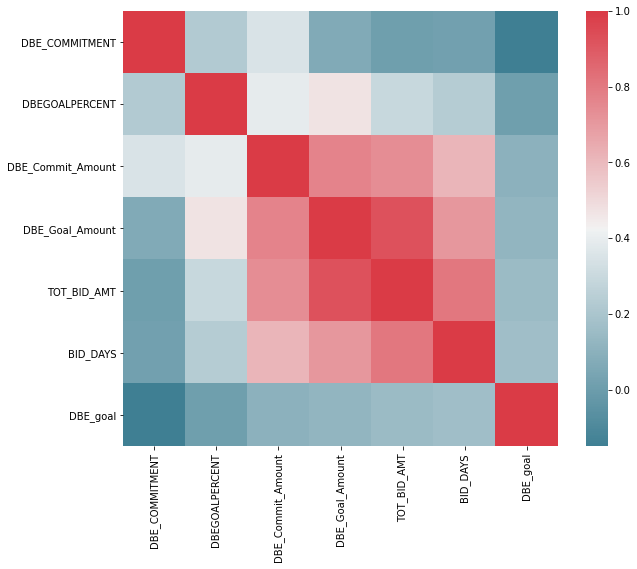

In [57]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data_copy.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [58]:
to_drop = [var for var in upper.columns if any(upper[var] > .90)]
to_drop

['TOT_BID_AMT']

In [59]:
for var in data_copy.columns:
    print(var, 'percent of missing values', data_copy[var].isnull().mean().round(3))

FUND_IND percent of missing values 0.0
FUNDTYPE percent of missing values 0.0
PROPOSAL_TYPE percent of missing values 0.0
DBE_COMMITMENT percent of missing values 0.0
DBEGOALPERCENT percent of missing values 0.0
DBE_Commit_Amount percent of missing values 0.0
DBE_Goal_Amount percent of missing values 0.0
TOT_BID_AMT percent of missing values 0.0
BID_DAYS percent of missing values 0.0
DBE_goal percent of missing values 0.0


In [60]:
for var in data_copy.columns:
    print(var, data_copy[var].unique(), '\n')

FUND_IND ['B' 'F'] 

FUNDTYPE ['0FED' 'FED' '0L24' 'L05E' 'L24E' '0LY2' 'LS3E' 'L1CE' 'L23E' 'FED2'
 '0402' '0F13' 'L11E'] 

PROPOSAL_TYPE ['INTERSECTION MODIFICATION AND TRAFFIC SIGNALS' 'BRIDGE AND APPROACHES'
 'BRIDGE AND APPROACHES AND GUARDRAIL' 'BRIDGE REHABILITATION'
 'GRADE, DRAIN, AND SURFACE' 'RESURFACE (ASPHALT)'
 'PAVEMENT REHABILITATION (P.C. CONCRETE)'
 'GRADE, DRAIN, SURFACE, AND BRIDGE' 'WIDENING AND RESURFACE (ASPHALT)'
 'GRADE, DRAIN, SURFACE, AND BRIDGE - DIVISION III'
 'INTERSECTION MODIFICATION' 'RESURFACE (ASPHALT) - DIVISION II'
 'BRIDGE AND APPROACHES - DIVISION III'
 'GRADE, DRAIN, SURFACE, AND BRIDGE - DIVISION IV' 'WIDEN AND RESURFACE'
 'RECONSTRUCT - ADD LANES' 'INTERSECTION MODIFICATION AND TRAFFIC SIGNAL'
 'SIGNING AND HIGH FRICTION SURFACE COURSE' 'WIDEN, RESURFACE, AND BRIDGE'
 'SURFACE' 'SAFETY IMPROVEMENT (GUARDRAIL AND CABLE BARRIER)'
 'RESURFACE (PC CONCRETE)'
 'SHOULDER IMPROVEMENT, RESURFACE (ASPHALT), AND BRIDGE'
 'RESURFACE (ASPHALT) AND BRIDGE R

In [61]:
for var in data_copy.columns:
    print(var,'\n', data_copy[var].value_counts()/len(data_copy))

FUND_IND 
 B    0.720339
F    0.279661
Name: FUND_IND, dtype: float64
FUNDTYPE 
 0FED    0.898305
FED     0.046610
L05E    0.012712
L24E    0.008475
LS3E    0.006356
L1CE    0.006356
0402    0.004237
L23E    0.004237
L11E    0.004237
0F13    0.002119
FED2    0.002119
0LY2    0.002119
0L24    0.002119
Name: FUNDTYPE, dtype: float64
PROPOSAL_TYPE 
 BRIDGE AND APPROACHES                                          0.480932
RESURFACE (ASPHALT)                                            0.129237
GRADE, DRAIN, SURFACE, AND BRIDGE                              0.082627
GRADE, DRAIN, AND SURFACE                                      0.074153
BRIDGE REHABILITATION                                          0.055085
WIDEN, RESURFACE, AND BRIDGE                                   0.008475
PEDESTRIAN IMPROVEMENTS (SIDEWALKS)                            0.008475
INTERSECTION MODIFICATION                                      0.008475
GRADE AND DRAIN                                                0.006356
PAV

In [62]:
data['DBE_goal'].value_counts()

1    429
0     43
Name: DBE_goal, dtype: int64

In [63]:
data.shape

(472, 10)

In [64]:
categorical = ['FUND_IND', 'FUNDTYPE', 'PROPOSAL_TYPE','DBE_goal']
discrete = ['DBEGOALPERCENT']
continuous = ['DBE_Commit_Amount', 'DBE_Goal_Amount','TOT_BID_AMT','DBE_COMMITMENT','BID_DAYS']
data.columns,'Number of Features:',len(data.columns)

(Index(['FUND_IND', 'FUNDTYPE', 'PROPOSAL_TYPE', 'DBE_COMMITMENT',
        'DBEGOALPERCENT', 'DBE_Commit_Amount', 'DBE_Goal_Amount', 'TOT_BID_AMT',
        'BID_DAYS', 'DBE_goal'],
       dtype='object'),
 'Number of Features:',
 10)

In [65]:
for var in data.columns:
    if data[var].isnull().sum() > 0:
        print(var, data[var].isnull().mean())

In [66]:
for var in categorical:
    print(var, 'has', data[var].nunique(), 'unique categories')

FUND_IND has 2 unique categories
FUNDTYPE has 13 unique categories
PROPOSAL_TYPE has 68 unique categories
DBE_goal has 2 unique categories


In [67]:
for var in discrete:
    print(var, 'has', data[var].nunique(), 'unique categories')

DBEGOALPERCENT has 18 unique categories


In [68]:
for var in categorical:
    print(data[var].nunique(),(data.groupby(var)[var].count()/len(data)))

2 FUND_IND
B    0.720339
F    0.279661
Name: FUND_IND, dtype: float64
13 FUNDTYPE
0402    0.004237
0F13    0.002119
0FED    0.898305
0L24    0.002119
0LY2    0.002119
FED     0.046610
FED2    0.002119
L05E    0.012712
L11E    0.004237
L1CE    0.006356
L23E    0.004237
L24E    0.008475
LS3E    0.006356
Name: FUNDTYPE, dtype: float64
68 PROPOSAL_TYPE
ASPHALT RESURFACE AND P.C. CONCRETE REHAB.                     0.002119
BRIDGE  AND APPROACHES - DIVISION VII                          0.002119
BRIDGE AND  APPROACHES                                         0.004237
BRIDGE AND APPROACHES                                          0.480932
BRIDGE AND APPROACHES - DIVISION II                            0.002119
BRIDGE AND APPROACHES - DIVISION III                           0.004237
BRIDGE AND APPROACHES - DIVISION IV                            0.002119
BRIDGE AND APPROACHES - DIVISION V                             0.002119
BRIDGE AND APPROACHES AND BRIDGE REHABILITATION                0.002119
B

In [69]:
for var in discrete:
     print(data[var].nunique(),(data.groupby(var)[var].count()/len(data)))

18 DBEGOALPERCENT
0.5     0.004237
1.0     0.033898
1.5     0.038136
2.0     0.182203
2.5     0.031780
3.0     0.197034
3.5     0.029661
4.0     0.156780
4.5     0.008475
5.0     0.131356
5.5     0.002119
6.0     0.114407
6.5     0.006356
7.0     0.042373
7.5     0.004237
8.0     0.008475
9.0     0.006356
10.0    0.002119
Name: DBEGOALPERCENT, dtype: float64


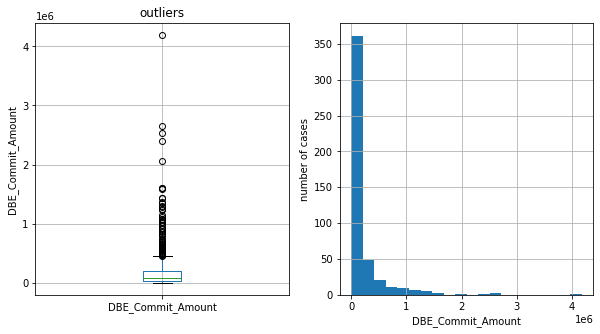

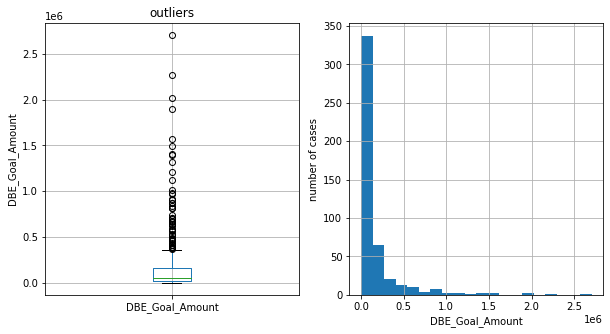

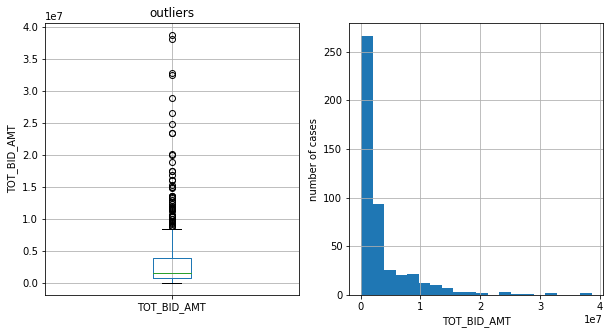

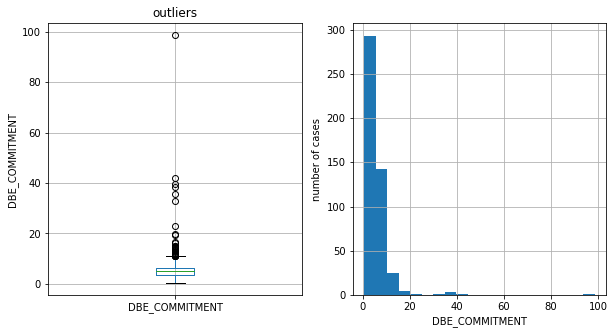

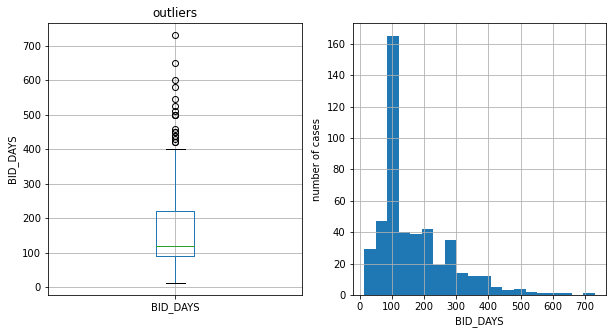

In [70]:
for var in continuous:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    fig = data.boxplot(column=var)
    fig.set_title('outliers')
    fig.set_ylabel(var)
    
    plt.subplot(1,2,2)
    fig = data[var].hist(bins=20)
    fig.set_ylabel('number of cases')
    fig.set_xlabel(var)    
    plt.show()

In [71]:
def diagnostic_plot(df, variable):
    plt.figure(figsize=(16, 4))
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

In [72]:
data_copy = data.copy()
data_copy['DBE_Commit_Amount'].skew(skipna = True)
data_copy['DBE_Commit_Amount_log'] = data_copy['DBE_Commit_Amount'].map(lambda x: np.log(x))
data_copy['DBE_Commit_Amount_rec'] = data_copy['DBE_Commit_Amount'].map(lambda x: np.reciprocal(x))
data_copy['DBE_Commit_Amount_sqrt'] = data_copy['DBE_Commit_Amount'].map(lambda x: np.sqrt(x))

In [73]:
data_copy['DBE_Commit_Amount'].skew(skipna = True)

4.5262232161389875

In [74]:
data_copy['DBE_Commit_Amount_log'].skew(skipna = True)

0.3216324078016303

In [75]:
data_copy['DBE_Commit_Amount_rec'].skew(skipna = True)

15.194083543231232

In [76]:
data_copy['DBE_Commit_Amount_sqrt'].skew(skipna = True)

2.028902314108477

In [77]:
data['DBE_Commit_Amount_log'] = data['DBE_Commit_Amount'].map(lambda x: np.log(x))

C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


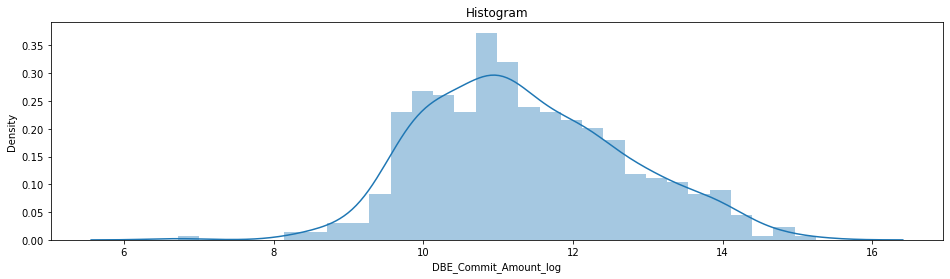

In [78]:
diagnostic_plot(data_copy, 'DBE_Commit_Amount_log')

In [79]:
data_copy['DBE_Goal_Amount'].skew(skipna = True)

4.157202320469542

In [80]:
data_copy['DBE_Goal_Amount_log'] = data_copy['DBE_Goal_Amount'].map(lambda x: np.log(x) if x > 0 else 0)
data_copy['DBE_Goal_Amount_rec'] = data_copy['DBE_Goal_Amount'].map(lambda x: np.reciprocal(x) if x > 0 else 0)
data_copy['DBE_Goal_Amount_sqrt'] = data_copy['DBE_Goal_Amount'].map(lambda x: np.sqrt(x))

In [81]:
data_copy['DBE_Goal_Amount_log'].skew(skipna = True)

0.27216812326922746

In [82]:
data_copy['DBE_Goal_Amount_rec'].skew(skipna = True)

9.983727501697622

In [83]:
data_copy['DBE_Goal_Amount_sqrt'].skew(skipna = True)

2.017816736547593

In [84]:
data['DBE_Goal_Amount_log'] = data['DBE_Goal_Amount'].map(lambda x: np.log(x) if x > 0 else 0)

In [85]:
data.drop(['DBE_Commit_Amount'], axis=1, inplace=True)

In [86]:
data.drop(['DBE_Goal_Amount'], axis=1, inplace=True)

In [87]:
data.shape

(472, 10)

C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


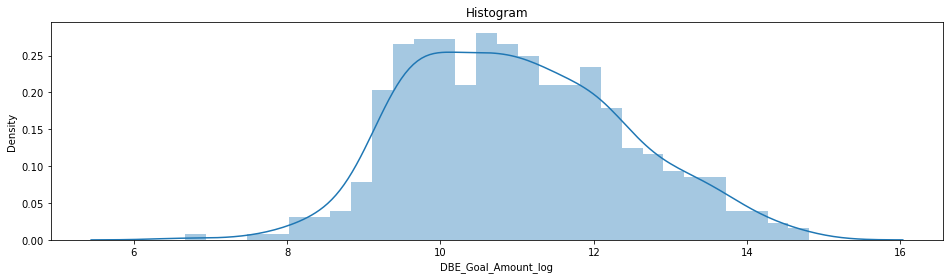

In [88]:
diagnostic_plot(data_copy, 'DBE_Goal_Amount_log')

In [89]:
data_copy['TOT_BID_AMT'].skew(skipna = True)

3.2637562738625983

In [90]:
data_copy['TOT_BID_AMT_log'] = data_copy['TOT_BID_AMT'].map(lambda x: np.log(x) if x > 0 else 0)
data_copy['TOT_BID_AMT_rec'] = data_copy['TOT_BID_AMT'].map(lambda x: np.reciprocal(x) if x > 0 else 0)
data_copy['TOT_BID_AMT_sqrt'] = data_copy['TOT_BID_AMT'].map(lambda x: np.sqrt(x))

In [91]:
data_copy['TOT_BID_AMT_log'].skew(skipna = True)

0.318914544237967

In [92]:
data_copy['TOT_BID_AMT_rec'].skew(skipna = True)

0.0

In [93]:
data_copy['TOT_BID_AMT_sqrt'].skew(skipna = True)

1.6287363552136287

C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


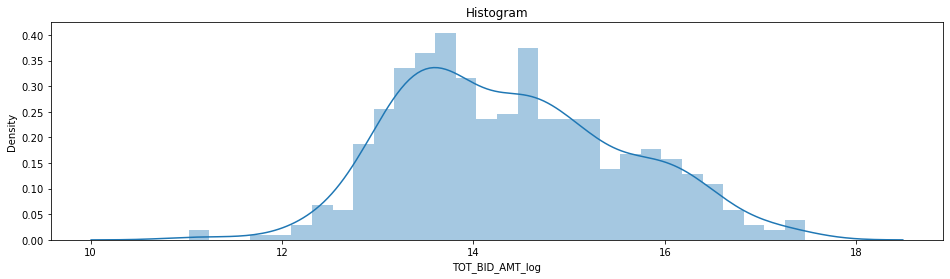

In [94]:
diagnostic_plot(data_copy, 'TOT_BID_AMT_log')

In [95]:
data['TOT_BID_AMT_log'] = data['TOT_BID_AMT'].map(lambda x: np.log(x) if x > 0 else 0)

In [96]:
data.drop(['TOT_BID_AMT'], axis=1, inplace=True)

In [97]:
data.shape

(472, 10)

In [98]:
data_copy['DBE_COMMITMENT'].skew(skipna = True)

8.901630749149783

In [99]:
data_copy['DBE_COMMITMENT_log'] = data_copy['DBE_COMMITMENT'].map(lambda x: np.log(x) if x > 0 else 0)
data_copy['DBE_COMMITMENT_rec'] = data_copy['DBE_COMMITMENT'].map(lambda x: np.reciprocal(x) if x > 0 else 0)
data_copy['DBE_COMMITMENT_sqrt'] = data_copy['DBE_COMMITMENT'].map(lambda x: np.sqrt(x))

In [100]:
data_copy['DBE_COMMITMENT_log'].skew(skipna = True)

0.4197024487103892

In [101]:
data_copy['DBE_COMMITMENT_rec'].skew(skipna = True)

4.295712923406511

In [102]:
data_copy['DBE_COMMITMENT_sqrt'].skew(skipna = True)

3.360574621393758

C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


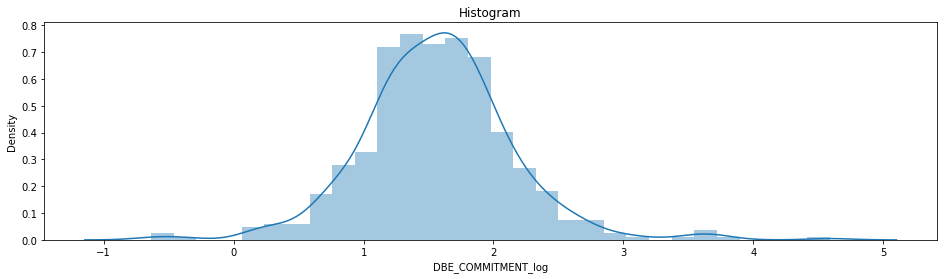

In [103]:
diagnostic_plot(data_copy, 'DBE_COMMITMENT_log')

In [104]:
data['DBE_COMMITMENT_log'] = data['DBE_COMMITMENT'].map(lambda x: np.log(x) if x > 0 else 0)

In [105]:
data.drop(['DBE_COMMITMENT'], axis=1, inplace=True)

In [106]:
data.shape

(472, 10)

In [107]:
data_copy['BID_DAYS'].skew(skipna = True)

1.475029846426311

In [108]:
data_copy['BID_DAYS_log'] = data_copy['BID_DAYS'].map(lambda x: np.log(x) if x > 0 else 0)
data_copy['BID_DAYS_rec'] = data_copy['BID_DAYS'].map(lambda x: np.reciprocal(x) if x > 0 else 0)
data_copy['BID_DAYS_sqrt'] = data_copy['BID_DAYS'].map(lambda x: np.sqrt(x))

In [109]:
data_copy['BID_DAYS_log'].skew(skipna = True)

-0.19767978033838707

In [110]:
data_copy['BID_DAYS_rec'].skew(skipna = True)

3.249020440521551

In [111]:
data_copy['BID_DAYS_sqrt'].skew(skipna = True)

0.6792491006338839

C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


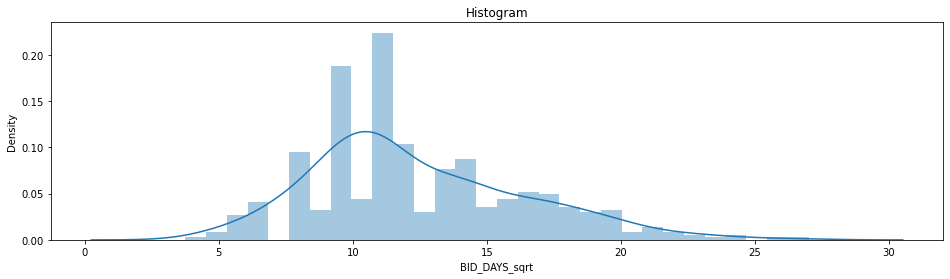

In [112]:
diagnostic_plot(data_copy, 'BID_DAYS_sqrt')

In [113]:
data['BID_DAYS_sqrt'] = data['BID_DAYS'].map(lambda x: np.sqrt(x))

In [114]:
data.drop(['BID_DAYS'], axis=1, inplace=True)

In [115]:
data.shape

(472, 10)

In [116]:
def find_boundaries(df, variable):
# calculate the boundaries anything outside the upper and lower boundaries is an outlier
    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()
    return upper_boundary, lower_boundary

In [117]:
upper_boundary, lower_boundary = find_boundaries(data, 'DBE_Commit_Amount_log')
upper_boundary, lower_boundary

(15.327041338696588, 7.382578643304168)

In [118]:
print('We have {} upper boundary outliers:'.format(len(data[data['DBE_Commit_Amount_log'] > upper_boundary])))
print('We have {} lower boundary outliers:'.format(len(data[data['DBE_Commit_Amount_log'] < lower_boundary])))

We have 0 upper boundary outliers:
We have 1 lower boundary outliers:


In [119]:
upper_boundary2, lower_boundary2 = find_boundaries(data, 'DBE_Goal_Amount_log')
upper_boundary2, lower_boundary2

(15.180316166147982, 6.814481470787463)

In [120]:
print('We have {} upper boundary outliers:'.format(len(data[data['DBE_Goal_Amount_log'] > upper_boundary2])))
print('We have {} lower boundary outliers:'.format(len(data[data['DBE_Goal_Amount_log'] < lower_boundary2])))

We have 0 upper boundary outliers:
We have 1 lower boundary outliers:


In [121]:
upper_boundary3, lower_boundary3 = find_boundaries(data, 'TOT_BID_AMT_log')
upper_boundary3, lower_boundary3

(17.882782470634407, 10.900325185089821)

In [122]:
print('We have {} upper boundary outliers:'.format(len(data[data['TOT_BID_AMT_log'] > upper_boundary3])))
print('We have {} lower boundary outliers:'.format(len(data[data['TOT_BID_AMT_log'] < lower_boundary3])))

We have 0 upper boundary outliers:
We have 0 lower boundary outliers:


In [123]:
upper_boundary4, lower_boundary4 = find_boundaries(data, 'DBE_COMMITMENT_log')
upper_boundary4, lower_boundary4

(3.3195437216172667, -0.18269102336455867)

In [124]:
print('We have {} upper boundary outliers:'.format(len(data[data['DBE_COMMITMENT_log'] > upper_boundary4])))
print('We have {} lower boundary outliers:'.format(len(data[data['DBE_COMMITMENT_log'] < lower_boundary4])))

We have 6 upper boundary outliers:
We have 3 lower boundary outliers:


In [125]:
upper_boundary5, lower_boundary5 = find_boundaries(data, 'BID_DAYS_sqrt')
upper_boundary5, lower_boundary5

(24.440210880284887, 0.40085401833560574)

In [126]:
print('We have {} upper boundary outliers:'.format(len(data[data['BID_DAYS_sqrt'] > upper_boundary5])))
print('We have {} lower boundary outliers:'.format(len(data[data['BID_DAYS_sqrt'] < lower_boundary5])))

We have 3 upper boundary outliers:
We have 0 lower boundary outliers:


In [127]:
data.shape

(472, 10)

In [128]:
# Identify the outliers 
outliers_DBE_Commit_Amount = np.where(data['DBE_Commit_Amount_log'] > upper_boundary, True, np.where(data['DBE_Commit_Amount_log'] < lower_boundary, True, False))
# trim the df of the outliers
data = data.loc[~(outliers_DBE_Commit_Amount)]

In [129]:
outliers_DBE_Goal_Amount = np.where(data['DBE_Goal_Amount_log'] > upper_boundary2, True, np.where(data['DBE_Goal_Amount_log'] < lower_boundary2, True, False))
data = data.loc[~(outliers_DBE_Goal_Amount)]

In [130]:
outliers_TOT_BID_AMT = np.where(data['TOT_BID_AMT_log'] > upper_boundary3, True, np.where(data['TOT_BID_AMT_log'] < lower_boundary3, True, False))
data = data.loc[~(outliers_TOT_BID_AMT)]

In [131]:
outliers_DBE_COMMITMENT = np.where(data['DBE_COMMITMENT_log'] > upper_boundary4, True, np.where(data['DBE_COMMITMENT_log'] < lower_boundary4, True, False))
data = data.loc[~(outliers_DBE_COMMITMENT)]

In [132]:
outliers_BID_DAYS = np.where(data['BID_DAYS_sqrt'] > upper_boundary5, True, np.where(data['BID_DAYS_sqrt'] < lower_boundary5, True, False))
data = data.loc[~(outliers_BID_DAYS)]

In [133]:
data.shape

(460, 10)

In [134]:
data['DBE_goal'].value_counts()/len(data)

1    0.91087
0    0.08913
Name: DBE_goal, dtype: float64

In [135]:
data['DBE_goal'].value_counts()

1    419
0     41
Name: DBE_goal, dtype: int64

In [136]:
data.dtypes 

FUND_IND                  object
FUNDTYPE                  object
PROPOSAL_TYPE             object
DBEGOALPERCENT           float64
DBE_goal                   int64
DBE_Commit_Amount_log    float64
DBE_Goal_Amount_log      float64
TOT_BID_AMT_log          float64
DBE_COMMITMENT_log       float64
BID_DAYS_sqrt            float64
dtype: object

In [137]:
data[discrete] = data[discrete].astype('O')
data['DBE_goal'] = data['DBE_goal'].astype('O')

In [138]:
data.dtypes

FUND_IND                  object
FUNDTYPE                  object
PROPOSAL_TYPE             object
DBEGOALPERCENT            object
DBE_goal                  object
DBE_Commit_Amount_log    float64
DBE_Goal_Amount_log      float64
TOT_BID_AMT_log          float64
DBE_COMMITMENT_log       float64
BID_DAYS_sqrt            float64
dtype: object

In [139]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('DBE_goal', axis=1),
    data['DBE_goal'],
    test_size=0.3,
    random_state=SEED)

In [140]:
data.dtypes
#categorical = ['PRIME_VEND_ID', 'FUND_IND', 'FUNDTYPE', 'PROPOSAL_TYPE','DBE_goal']
#discrete = ['DBEGOALPERCENT','BID_DAYS']
#continuous = ['DBE_Commit_Amount', 'DBE_Goal_Amount','TOT_BID_AMT','DBE_COMMITMENT']

FUND_IND                  object
FUNDTYPE                  object
PROPOSAL_TYPE             object
DBEGOALPERCENT            object
DBE_goal                  object
DBE_Commit_Amount_log    float64
DBE_Goal_Amount_log      float64
TOT_BID_AMT_log          float64
DBE_COMMITMENT_log       float64
BID_DAYS_sqrt            float64
dtype: object

In [141]:
feat_transform = pipe([
# Encoding rare categories for categorical and discrete features (Less than 1% is rare)
('rare_label_encoder', RareLabelEncoder(
tol=0.01, n_categories=6, variables=['FUNDTYPE','PROPOSAL_TYPE','DBEGOALPERCENT']
)),
# We will use one_hot_encoding for categorical features
('one_hot_categorical_encoder', OneHotEncoder(variables=['FUND_IND','FUNDTYPE','PROPOSAL_TYPE','DBEGOALPERCENT'],drop_last=True))
# We are going to use ordinal encoding according to the target mean to the target feature
#('ordinal_categorical_encoder', OrdinalEncoder(encoding_method='ordered',variables=['DBEGOALPERCENT','BID_DAYS']))
])

In [142]:
X_train.dtypes

FUND_IND                  object
FUNDTYPE                  object
PROPOSAL_TYPE             object
DBEGOALPERCENT            object
DBE_Commit_Amount_log    float64
DBE_Goal_Amount_log      float64
TOT_BID_AMT_log          float64
DBE_COMMITMENT_log       float64
BID_DAYS_sqrt            float64
dtype: object

In [143]:
feat_transform.fit(X_train, y_train)
X_train_clean = feat_transform.transform(X_train)
X_test_clean = feat_transform.transform(X_test)
X_train_clean.head()

,DBE_Commit_Amount_log,DBE_Goal_Amount_log,TOT_BID_AMT_log,DBE_COMMITMENT_log,BID_DAYS_sqrt,FUND_IND_B,FUNDTYPE_0FED,FUNDTYPE_Rare,FUNDTYPE_FED,PROPOSAL_TYPE_BRIDGE AND APPROACHES,PROPOSAL_TYPE_RESURFACE (ASPHALT),PROPOSAL_TYPE_PEDESTRIAN IMPROVEMENTS (SIDEWALKS),PROPOSAL_TYPE_Rare,PROPOSAL_TYPE_BRIDGE REHABILITATION,"PROPOSAL_TYPE_WIDEN, RESURFACE, AND BRIDGE","PROPOSAL_TYPE_GRADE, DRAIN, AND SURFACE","PROPOSAL_TYPE_GRADE, DRAIN, SURFACE, AND BRIDGE",DBEGOALPERCENT_3.0,DBEGOALPERCENT_5.0,DBEGOALPERCENT_4.0,DBEGOALPERCENT_2.5,DBEGOALPERCENT_2.0,DBEGOALPERCENT_7.0,DBEGOALPERCENT_6.0,DBEGOALPERCENT_1.5,DBEGOALPERCENT_Rare,DBEGOALPERCENT_3.5,DBEGOALPERCENT_8.0
112,9.505460,9.505460,13.012018,1.098612,9.486833,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
438,11.155784,11.151792,14.147524,1.613430,10.000000,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
440,9.817625,9.253733,12.472609,1.950187,3.741657,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
122,9.344184,8.647045,12.335925,1.613430,10.000000,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
118,11.283388,10.755705,14.667728,1.220830,13.416408,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [144]:
X_train_clean.shape

(322, 28)

In [145]:
X_test_clean.shape

(138, 28)

In [146]:
scaler = StandardScaler()
scaler.fit(X_train_clean)
X_train_std = scaler.transform(X_train_clean)
X_test_std = scaler.transform(X_test_clean)

In [147]:
X_train_clean.head(4)

,DBE_Commit_Amount_log,DBE_Goal_Amount_log,TOT_BID_AMT_log,DBE_COMMITMENT_log,BID_DAYS_sqrt,FUND_IND_B,FUNDTYPE_0FED,FUNDTYPE_Rare,FUNDTYPE_FED,PROPOSAL_TYPE_BRIDGE AND APPROACHES,PROPOSAL_TYPE_RESURFACE (ASPHALT),PROPOSAL_TYPE_PEDESTRIAN IMPROVEMENTS (SIDEWALKS),PROPOSAL_TYPE_Rare,PROPOSAL_TYPE_BRIDGE REHABILITATION,"PROPOSAL_TYPE_WIDEN, RESURFACE, AND BRIDGE","PROPOSAL_TYPE_GRADE, DRAIN, AND SURFACE","PROPOSAL_TYPE_GRADE, DRAIN, SURFACE, AND BRIDGE",DBEGOALPERCENT_3.0,DBEGOALPERCENT_5.0,DBEGOALPERCENT_4.0,DBEGOALPERCENT_2.5,DBEGOALPERCENT_2.0,DBEGOALPERCENT_7.0,DBEGOALPERCENT_6.0,DBEGOALPERCENT_1.5,DBEGOALPERCENT_Rare,DBEGOALPERCENT_3.5,DBEGOALPERCENT_8.0
112,9.505460,9.505460,13.012018,1.098612,9.486833,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
438,11.155784,11.151792,14.147524,1.613430,10.000000,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
440,9.817625,9.253733,12.472609,1.950187,3.741657,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
122,9.344184,8.647045,12.335925,1.613430,10.000000,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [152]:
col_names = ['DBE_Commit_Amount_log','DBE_Goal_Amount_log','TOT_BID_AMT_log','DBE_COMMITMENT_log','BID_DAYS_sqrt','FUND_IND_B','FUNDTYPE_0FED','FUNDTYPE_Rare','FUNDTYPE_FED','PROPOSAL_TYPE_BRIDGE AND APPROACHES','PROPOSAL_TYPE_RESURFACE (ASPHALT)','PROPOSAL_TYPE_PEDESTRIAN IMPROVEMENTS (SIDEWALKS)','PROPOSAL_TYPE_Rare','PROPOSAL_TYPE_BRIDGE REHABILITATION','PROPOSAL_TYPE_WIDEN, RESURFACE, AND BRIDGE','ROPOSAL_TYPE_GRADE, DRAIN, AND SURFACE','PROPOSAL_TYPE_GRADE, DRAIN, SURFACE, AND BRIDGE','DBEGOALPERCENT_3.0','DBEGOALPERCENT_5.0','DBEGOALPERCENT_4.0','DBEGOALPERCENT_2.5','DBEGOALPERCENT_2.0','DBEGOALPERCENT_7.0','DBEGOALPERCENT_6.0','DBEGOALPERCENT_1.5','DBEGOALPERCENT_Rare','DBEGOALPERCENT_3.5','DBEGOALPERCENT_8.0']

In [153]:
X_train_std_df = pd.DataFrame(X_train_std, columns=col_names)
X_test_std_df = pd.DataFrame(X_test_std, columns=col_names)

In [154]:
X_train_std_df.head()

,DBE_Commit_Amount_log,DBE_Goal_Amount_log,TOT_BID_AMT_log,DBE_COMMITMENT_log,BID_DAYS_sqrt,FUND_IND_B,FUNDTYPE_0FED,FUNDTYPE_Rare,FUNDTYPE_FED,PROPOSAL_TYPE_BRIDGE AND APPROACHES,PROPOSAL_TYPE_RESURFACE (ASPHALT),PROPOSAL_TYPE_PEDESTRIAN IMPROVEMENTS (SIDEWALKS),PROPOSAL_TYPE_Rare,PROPOSAL_TYPE_BRIDGE REHABILITATION,"PROPOSAL_TYPE_WIDEN, RESURFACE, AND BRIDGE","ROPOSAL_TYPE_GRADE, DRAIN, AND SURFACE","PROPOSAL_TYPE_GRADE, DRAIN, SURFACE, AND BRIDGE",DBEGOALPERCENT_3.0,DBEGOALPERCENT_5.0,DBEGOALPERCENT_4.0,DBEGOALPERCENT_2.5,DBEGOALPERCENT_2.0,DBEGOALPERCENT_7.0,DBEGOALPERCENT_6.0,DBEGOALPERCENT_1.5,DBEGOALPERCENT_Rare,DBEGOALPERCENT_3.5,DBEGOALPERCENT_8.0
0,-1.451832,-1.120233,-1.229902,-0.968384,-0.759491,0.651751,0.32053,-0.188069,-0.221043,1.012500,-0.371227,-0.112154,-0.433811,-0.228665,-0.112154,-0.28379,-0.264135,1.932691,-0.381978,-0.418548,-0.159617,-0.502910,-0.228665,-0.365791,-0.16957,-0.179029,-0.159617,-0.112154
1,-0.151971,0.093822,-0.219143,0.111707,-0.625935,0.651751,0.32053,-0.188069,-0.221043,-0.987654,2.693772,-0.112154,-0.433811,-0.228665,-0.112154,-0.28379,-0.264135,-0.517413,2.617949,-0.418548,-0.159617,-0.502910,-0.228665,-0.365791,-0.16957,-0.179029,-0.159617,-0.112154
2,-1.205959,-1.305864,-1.710052,0.818225,-2.254717,-1.534329,0.32053,-0.188069,-0.221043,-0.987654,2.693772,-0.112154,-0.433811,-0.228665,-0.112154,-0.28379,-0.264135,-0.517413,-0.381978,2.389212,-0.159617,-0.502910,-0.228665,-0.365791,-0.16957,-0.179029,-0.159617,-0.112154
3,-1.578860,-1.753255,-1.831721,0.111707,-0.625935,0.651751,0.32053,-0.188069,-0.221043,-0.987654,-0.371227,8.916277,-0.433811,-0.228665,-0.112154,-0.28379,-0.264135,-0.517413,-0.381978,-0.418548,6.264982,-0.502910,-0.228665,-0.365791,-0.16957,-0.179029,-0.159617,-0.112154
4,-0.051465,-0.198264,0.243912,-0.711970,0.263212,0.651751,0.32053,-0.188069,-0.221043,-0.987654,-0.371227,-0.112154,2.305152,-0.228665,-0.112154,-0.28379,-0.264135,-0.517413,-0.381978,-0.418548,-0.159617,1.988428,-0.228665,-0.365791,-0.16957,-0.179029,-0.159617,-0.112154


In [155]:
X_train_std_df.shape

(322, 28)

In [156]:
X_train_std_df.dtypes

DBE_Commit_Amount_log                                float64
DBE_Goal_Amount_log                                  float64
TOT_BID_AMT_log                                      float64
DBE_COMMITMENT_log                                   float64
BID_DAYS_sqrt                                        float64
FUND_IND_B                                           float64
FUNDTYPE_0FED                                        float64
FUNDTYPE_Rare                                        float64
FUNDTYPE_FED                                         float64
PROPOSAL_TYPE_BRIDGE AND APPROACHES                  float64
PROPOSAL_TYPE_RESURFACE (ASPHALT)                    float64
PROPOSAL_TYPE_PEDESTRIAN IMPROVEMENTS (SIDEWALKS)    float64
PROPOSAL_TYPE_Rare                                   float64
PROPOSAL_TYPE_BRIDGE REHABILITATION                  float64
PROPOSAL_TYPE_WIDEN, RESURFACE, AND BRIDGE           float64
ROPOSAL_TYPE_GRADE, DRAIN, AND SURFACE               float64
PROPOSAL_TYPE_GRADE, DRA

In [157]:
y_train=y_train.astype('int')

In [158]:
y_train.value_counts()

1    298
0     24
Name: DBE_goal, dtype: int64

In [159]:
y_test=y_test.astype('int')

In [160]:
y_test.value_counts()

1    121
0     17
Name: DBE_goal, dtype: int64

In [161]:
y_test.dtypes

dtype('int32')

In [162]:
y_train.dtypes

dtype('int32')

[0.70333333 0.75333333 0.83333333 0.43389831 0.80338983]
Logistic Regression: Avg CV roc_auc using all features on training data: 0.7055
Logistic Regression: roc_auc w/all features on test data 0.9835:
              precision    recall  f1-score   support

           0       0.33      0.06      0.10        17
           1       0.88      0.98      0.93       121

    accuracy                           0.87       138
   macro avg       0.61      0.52      0.51       138
weighted avg       0.81      0.87      0.83       138

[[  1  16]
 [  2 119]]


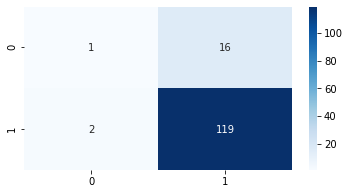

-------------------------------------------------------
[0.51       0.77666667 0.75208333 0.43220339 0.51525424]
Random Forest: Avg CV roc_auc using all features on training data: 0.5972
Random Forest: roc_auc w/all features on test data 0.9917:
              precision    recall  f1-score   support

           0       0.50      0.06      0.11        17
           1       0.88      0.99      0.93       121

    accuracy                           0.88       138
   macro avg       0.69      0.53      0.52       138
weighted avg       0.84      0.88      0.83       138

[[  1  16]
 [  1 120]]


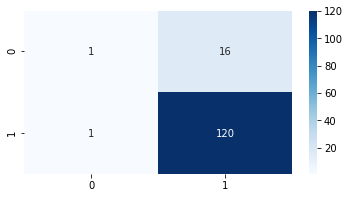

-------------------------------------------------------
[0.63       0.71       0.83333333 0.41186441 0.69322034]
Naive Bayes: Avg CV roc_auc using all features on training data: 0.6557
Naive Bayes: roc_auc w/all features on test data 0.3223:
              precision    recall  f1-score   support

           0       0.14      0.76      0.23        17
           1       0.91      0.32      0.48       121

    accuracy                           0.38       138
   macro avg       0.52      0.54      0.35       138
weighted avg       0.81      0.38      0.45       138

[[13  4]
 [82 39]]


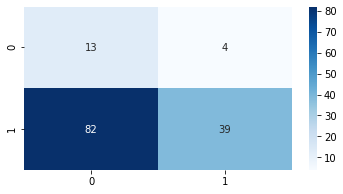

-------------------------------------------------------
[0.61       0.74       0.71041667 0.46779661 0.62711864]
Gradient Boosting Classifier: Avg CV roc_auc using all features on training data: 0.6311
Gradient Boosting Classifier: roc_auc w/all features on test data 0.9752:
              precision    recall  f1-score   support

           0       0.40      0.12      0.18        17
           1       0.89      0.98      0.93       121

    accuracy                           0.87       138
   macro avg       0.64      0.55      0.56       138
weighted avg       0.83      0.87      0.84       138

[[  2  15]
 [  3 118]]


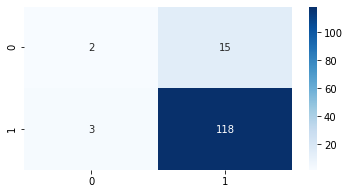

-------------------------------------------------------
[0.45       0.46666667 0.6        0.43220339 0.47457627]
Decision Tree: Avg CV roc_auc using all features on training data: 0.4847
Decision Tree: roc_auc w/all features on test data 0.9339:
              precision    recall  f1-score   support

           0       0.33      0.24      0.28        17
           1       0.90      0.93      0.91       121

    accuracy                           0.85       138
   macro avg       0.62      0.58      0.60       138
weighted avg       0.83      0.85      0.84       138

[[  4  13]
 [  8 113]]


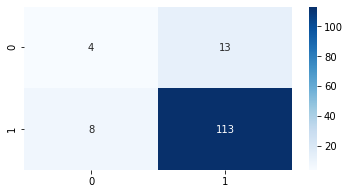

-------------------------------------------------------
[0.62333333 0.73       0.81666667 0.44067797 0.59322034]
Support Vector Machine: Avg CV roc_auc using all features on training data: 0.6408
Support Vector Machine: roc_auc w/all features on test data 1.0:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.88      1.00      0.93       121

    accuracy                           0.88       138
   macro avg       0.44      0.50      0.47       138
weighted avg       0.77      0.88      0.82       138

[[  0  17]
 [  0 121]]


C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abdul\Anaconda3\envs\IT_project\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


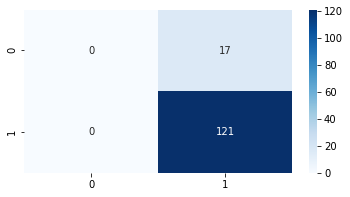

-------------------------------------------------------
[0.57166667 0.69833333 0.7875     0.44067797 0.49152542]
Nearest Neighbors: Avg CV roc_auc using all features on training data: 0.5979
Nearest Neighbors: roc_auc w/all features on test data 0.9917:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.88      0.99      0.93       121

    accuracy                           0.87       138
   macro avg       0.44      0.50      0.47       138
weighted avg       0.77      0.87      0.82       138

[[  0  17]
 [  1 120]]


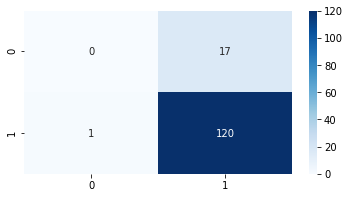

-------------------------------------------------------
[0.64333333 0.76       0.83333333 0.41694915 0.78305085]
Neural Net: Avg CV roc_auc using all features on training data: 0.6873
Neural Net: roc_auc w/all features on test data 0.9504:
              precision    recall  f1-score   support

           0       0.33      0.18      0.23        17
           1       0.89      0.95      0.92       121

    accuracy                           0.86       138
   macro avg       0.61      0.56      0.58       138
weighted avg       0.82      0.86      0.84       138

[[  3  14]
 [  6 115]]


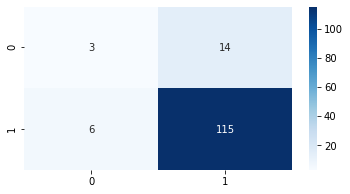

-------------------------------------------------------


In [163]:
models = []
models.append(('Logistic Regression', LogisticRegression(penalty= 'l2', solver='saga',max_iter=10000, random_state=42)))
models.append(('Random Forest', RandomForestClassifier(n_estimators=100,random_state=42)))
models.append(('Naive Bayes', GaussianNB()))
models.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('Support Vector Machine', svm.SVC(gamma = 'auto')))
models.append(('Nearest Neighbors', KNeighborsClassifier()))
models.append(('Neural Net',  MLPClassifier(solver='adam', alpha=0.0001,learning_rate='constant',max_iter=2000, learning_rate_init=0.001,random_state=42)))
base_model_train = []
base_model_test = []
for name, classifier in models:
    scores = cross_val_score(classifier, X_train_std_df, y_train, cv=5, scoring='roc_auc')
    base_model_train.append(scores.mean().round(4))
    print(scores)
    print('{}: Avg CV roc_auc using all features on training data: {}'.format(name, scores.mean().round(4)))
    
    classifier.fit(X_train_std_df, y_train)
    y_preds = classifier.predict(X_test_std_df)
    test_recall = recall_score(y_test, y_preds, average='binary')
    test_class = classification_report(y_test, y_preds)
    cnf_matrix = confusion_matrix(y_test, y_preds)
    base_model_test.append(test_recall.round(4))
    print('{}: roc_auc w/all features on test data {}:'.format(name, test_recall.round(4)))
    print(test_class)
    print(cnf_matrix)
    plt.figure(figsize=(6,3))
    sns.heatmap(cnf_matrix, annot=True,cmap='Blues', fmt='g')
    plt.show()
    print('-------------------------------------------------------')

### Model 1: Entire Feature Set & Balanced w/SMOTE


In [164]:
X_train_std_df.dtypes

DBE_Commit_Amount_log                                float64
DBE_Goal_Amount_log                                  float64
TOT_BID_AMT_log                                      float64
DBE_COMMITMENT_log                                   float64
BID_DAYS_sqrt                                        float64
FUND_IND_B                                           float64
FUNDTYPE_0FED                                        float64
FUNDTYPE_Rare                                        float64
FUNDTYPE_FED                                         float64
PROPOSAL_TYPE_BRIDGE AND APPROACHES                  float64
PROPOSAL_TYPE_RESURFACE (ASPHALT)                    float64
PROPOSAL_TYPE_PEDESTRIAN IMPROVEMENTS (SIDEWALKS)    float64
PROPOSAL_TYPE_Rare                                   float64
PROPOSAL_TYPE_BRIDGE REHABILITATION                  float64
PROPOSAL_TYPE_WIDEN, RESURFACE, AND BRIDGE           float64
ROPOSAL_TYPE_GRADE, DRAIN, AND SURFACE               float64
PROPOSAL_TYPE_GRADE, DRA

[0.69333333 0.68333333 0.68333333 0.33559322 0.8440678 ]
Logistic Regression: Avg CV roc_auc w/All Reatures: 0.6479
Logistic Regression: roc_auc w/All Features on test data 0.8099:
              precision    recall  f1-score   support

           0       0.18      0.29      0.22        17
           1       0.89      0.81      0.85       121

    accuracy                           0.75       138
   macro avg       0.53      0.55      0.54       138
weighted avg       0.80      0.75      0.77       138

[[ 5 12]
 [23 98]]


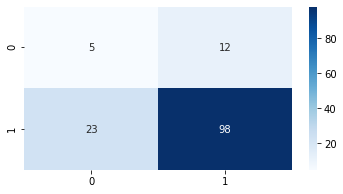

-------------------------------------------------------
[0.54833333 0.77833333 0.73125    0.56610169 0.71694915]
Random Forest: Avg CV roc_auc w/All Reatures: 0.6682
Random Forest: roc_auc w/All Features on test data 0.9174:
              precision    recall  f1-score   support

           0       0.23      0.18      0.20        17
           1       0.89      0.92      0.90       121

    accuracy                           0.83       138
   macro avg       0.56      0.55      0.55       138
weighted avg       0.81      0.83      0.82       138

[[  3  14]
 [ 10 111]]


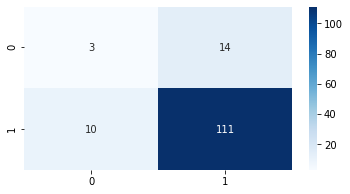

-------------------------------------------------------
[0.57333333 0.57666667 0.66041667 0.37627119 0.76949153]
Naive Bayes: Avg CV roc_auc w/All Reatures: 0.5912
Naive Bayes: roc_auc w/All Features on test data 0.5041:
              precision    recall  f1-score   support

           0       0.10      0.41      0.17        17
           1       0.86      0.50      0.64       121

    accuracy                           0.49       138
   macro avg       0.48      0.46      0.40       138
weighted avg       0.77      0.49      0.58       138

[[ 7 10]
 [60 61]]


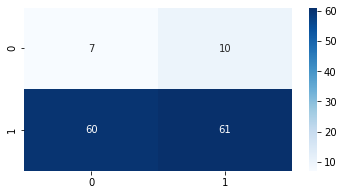

-------------------------------------------------------
[0.50666667 0.69666667 0.7375     0.34915254 0.75932203]
Gradient Boosting Classifier: Avg CV roc_auc w/All Reatures: 0.6099
Gradient Boosting Classifier: roc_auc w/All Features on test data 0.9091:
              precision    recall  f1-score   support

           0       0.31      0.29      0.30        17
           1       0.90      0.91      0.91       121

    accuracy                           0.83       138
   macro avg       0.61      0.60      0.60       138
weighted avg       0.83      0.83      0.83       138

[[  5  12]
 [ 11 110]]


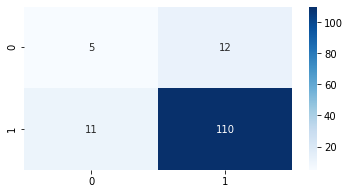

-------------------------------------------------------
[0.40833333 0.625      0.55833333 0.40677966 0.55762712]
Decision Tree: Avg CV roc_auc w/All Reatures: 0.5112
Decision Tree: roc_auc w/All Features on test data 0.9174:
              precision    recall  f1-score   support

           0       0.33      0.29      0.31        17
           1       0.90      0.92      0.91       121

    accuracy                           0.84       138
   macro avg       0.62      0.61      0.61       138
weighted avg       0.83      0.84      0.84       138

[[  5  12]
 [ 10 111]]


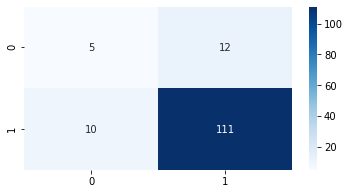

-------------------------------------------------------
[0.56666667 0.75666667 0.64166667 0.40677966 0.77966102]
Support Vector Machine: Avg CV roc_auc w/All Reatures: 0.6303
Support Vector Machine: roc_auc w/All Features on test data 0.8926:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.86      0.89      0.88       121

    accuracy                           0.78       138
   macro avg       0.43      0.45      0.44       138
weighted avg       0.76      0.78      0.77       138

[[  0  17]
 [ 13 108]]


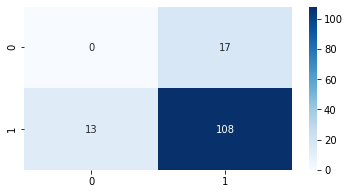

-------------------------------------------------------
[0.455      0.685      0.74166667 0.43220339 0.44237288]
Nearest Neighbors: Avg CV roc_auc w/All Reatures: 0.5512
Nearest Neighbors: roc_auc w/All Features on test data 0.9174:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.87      0.92      0.89       121

    accuracy                           0.80       138
   macro avg       0.43      0.46      0.45       138
weighted avg       0.76      0.80      0.78       138

[[  0  17]
 [ 10 111]]


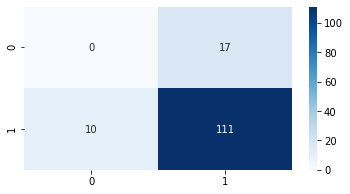

-------------------------------------------------------
[0.49333333 0.70333333 0.825      0.43389831 0.8       ]
Neural Net: Avg CV roc_auc w/All Reatures: 0.6511
Neural Net: roc_auc w/All Features on test data 0.9174:
              precision    recall  f1-score   support

           0       0.17      0.12      0.14        17
           1       0.88      0.92      0.90       121

    accuracy                           0.82       138
   macro avg       0.52      0.52      0.52       138
weighted avg       0.79      0.82      0.81       138

[[  2  15]
 [ 10 111]]


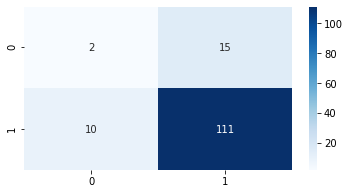

-------------------------------------------------------


In [169]:
sm = SMOTENC(random_state=42, categorical_features=[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26])
X_train_std_sm, y_train_sm = sm.fit_resample(X_train_std_df, y_train)
model1_train = []
model1_test = []
for name, classifier in models:
    pipeline = make_pipeline(sm, classifier)
    scores = cross_val_score(pipeline, X_train_std_df, y_train, cv=5, scoring='roc_auc')
    model1_train.append(scores.mean().round(4))
    print(scores)
    print('{}: Avg CV roc_auc w/All Reatures: {}'.format(name, scores.mean().round(4)))
    
    classifier.fit(X_train_std_sm, y_train_sm)
    y_preds = classifier.predict(X_test_std_df)
    test_recall = recall_score(y_test, y_preds)
    test_class = classification_report(y_test, y_preds)
    cnf_matrix = confusion_matrix(y_test, y_preds)
    model1_test.append(test_recall.round(4))
    print('{}: roc_auc w/All Features on test data {}:'.format(name, test_recall.round(4)))
    print(test_class)
    print(cnf_matrix)
    plt.figure(figsize=(6,3))
    sns.heatmap(cnf_matrix, annot=True,cmap='Blues', fmt='g')
    plt.show()
    print('-------------------------------------------------------')

In [221]:
rf_selector = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
rf_selector.fit(X_train_std_sm, y_train_sm)
feature_imp = pd.Series(rf_selector.feature_importances_, index=X_train_std_df.columns).sort_values(ascending=False)
#feature_imp[:30]

In [198]:
feature_imp

DBE_COMMITMENT_log                                 0.138865
TOT_BID_AMT_log                                    0.130116
DBEGOALPERCENT_1.0                                 0.128403
DBE_Goal_Amount_log                                0.113780
BID_DAYS_sqrt                                      0.093067
DBE_Commit_Amount_log                              0.091915
PROPOSAL_TYPE_BRIDGE AND APPROACHES                0.064290
DBEGOALPERCENT_6.0                                 0.050591
FUND_IND_B                                         0.044034
FUNDTYPE_0FED                                      0.020182
DBEGOALPERCENT_5.0                                 0.019309
DBEGOALPERCENT_7.0                                 0.017682
DBEGOALPERCENT_3.5                                 0.014295
FUNDTYPE_Rare                                      0.012480
PROPOSAL_TYPE_BRIDGE REHABILITATION                0.010615
PROPOSAL_TYPE_GRADE, DRAIN, AND SURFACE            0.008901
PROPOSAL_TYPE_Rare                      

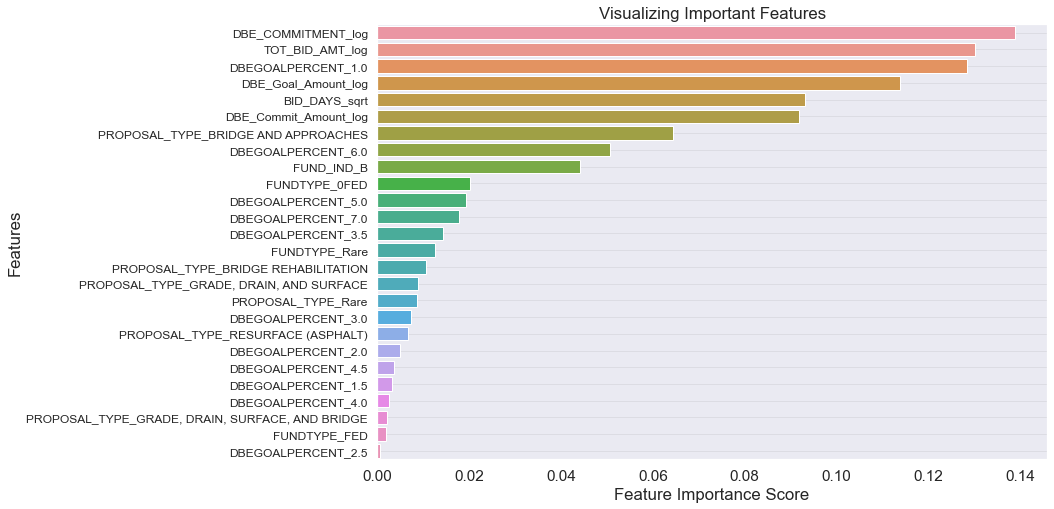

In [213]:
X_train_rf = X_train_std_df[feature_imp.index]
X_test_rf = X_test_std_df[feature_imp.index]
plt.figure(figsize=(12,8))
sns.barplot(x=feature_imp[0:30], y=feature_imp.index[0:30])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.yticks(fontsize=12)
plt.grid(which='major', color='#666666', linestyle='-', alpha=0.1)
plt.show()

In [218]:
clf_lr = LogisticRegression(solver='saga',max_iter=10000, random_state=SEED)
penalty = ['l1','l2']
C = [0.001,0.002,0.003,0.005,1,10,100,1000]
skf = StratifiedKFolnm.,d(n_splits=5)
pipeline = make_pipeline(sm, clf_lr)
param_grid = dict(logisticregression__penalty=penalty,
                  logisticregression__C=C)
grid = GridSearchCV(pipeline, 
                    param_grid=param_grid,
                    scoring='roc_auc', 
                    verbose=1, cv=skf)
grid_results = grid.fit(X_train_std_sm, y_train_sm) 
print('Best Score: ', grid_results.best_score_)
print('Best Params: ', grid_results.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Score:  0.9006755886635827
Best Params:  {'logisticregression__C': 1, 'logisticregression__penalty': 'l2'}
